# Notebook to plot results from a `TDinf` run

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import scipy.linalg as sl

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_palette('colorblind')

from time_domain_gw_inference import group_postprocess, utils, run_sampler, waveform_h5s

### Load in result

Results from `TDinf` runs can easily be loaded in using the `group_postprocess` module:

In [2]:
# Load in the result
result = group_postprocess.load_run_settings_from_directory('output')

The result object has helpful keys:
- `dir` tells you the directory where the output lives, relative to this notebook
- `runs` has `args`, `kwargs` and the `likelihood_manager` for these each cutoff time
- `dfs` has `pandas` `DataFrames` containing the posterior samples for each of the cutoff times

In [3]:
# Extract the likelihood_manager for easy use
lm = result['runs']['full']['likelihood_manager']

### Plot posterior distributions for the full run and pre/post cutoff times

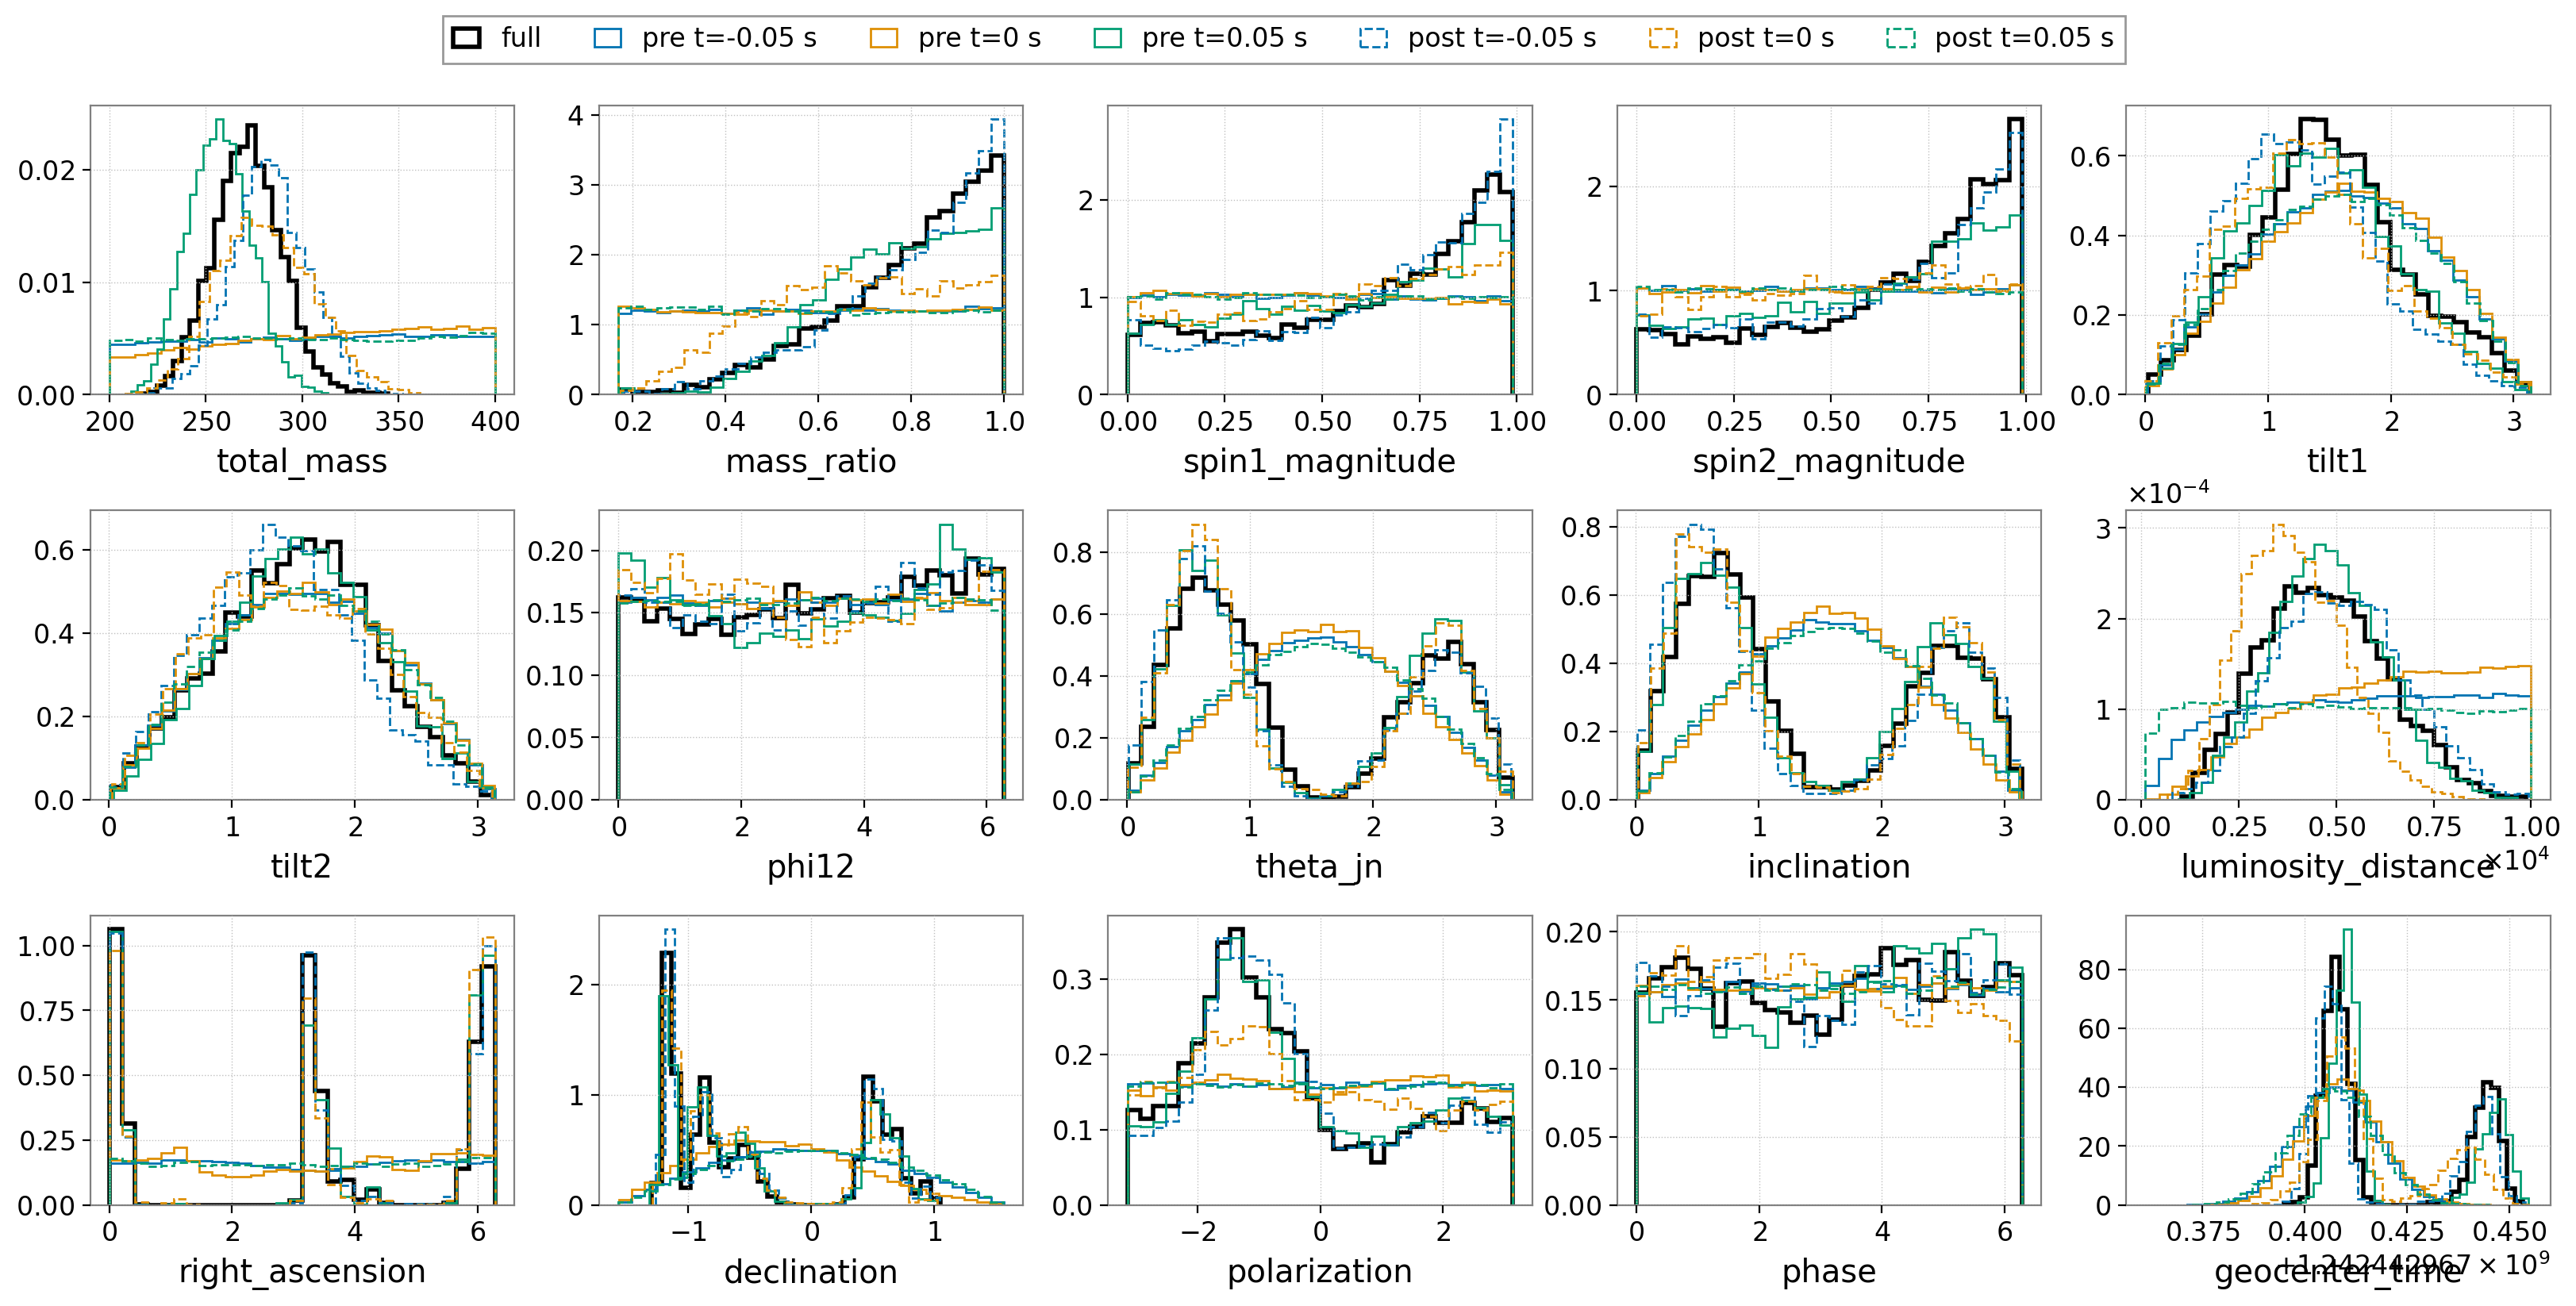

In [7]:
params_to_plot = ['total_mass', 'mass_ratio', 'spin1_magnitude', 'spin2_magnitude',
           'tilt1', 'tilt2', 'phi12', 'theta_jn', 'inclination','luminosity_distance',  
                  'right_ascension', 'declination', 'polarization', 'phase', 'geocenter_time']

fig, axes = plt.subplots(3,5,figsize=(20,9))

for ax, p in zip(axes.flatten(), params_to_plot):
    
    hist_kws = dict(density=True, histtype='step', bins=30) 

    ax.hist(result['dfs']['full'][p], **hist_kws, lw=2, color='k', label='full')

    ax.hist(result['dfs']['pre_-0.05'][p], **hist_kws, label='pre t=-0.05 s', color='C0')
    ax.hist(result['dfs']['pre_0.0'][p], **hist_kws, label='pre t=0 s', color='C1')
    ax.hist(result['dfs']['pre_0.05'][p], **hist_kws, label='pre t=0.05 s', color='C2')
    
    ax.hist(result['dfs']['post_-0.05'][p], **hist_kws, label='post t=-0.05 s', color='C0', ls='--')
    ax.hist(result['dfs']['post_0.0'][p], **hist_kws, label='post t=0 s', color='C1', ls='--')
    ax.hist(result['dfs']['post_0.05'][p], **hist_kws, label='post t=0.05 s', color='C2', ls='--')
    
    ax.set_xlabel(p)
    ax.grid(color='silver', ls=':')

axes[0][0].legend(ncols=7, loc='lower left', bbox_to_anchor=(0.8,1.1))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

### Plot strain and waveform reconstructions

For easy visualization, generate the whitened strain and waveform reconstructions:

In [8]:
# Get whitened strain 
data_dict_wh =  utils.whitenData_dict_TD(lm.data_dict, lm)

In [9]:
# Load waveform reconstructions from the full run
wfs_full = waveform_h5s.load_waveform_h5py(f'output/waveforms/full_waveforms.h5')

# Load waveform reconstructions post t=0 only
wfs_rd = waveform_h5s.load_waveform_h5py(f'output/waveforms/post_0.0_waveforms.h5')

In [10]:
# Whiten waveform reconstructions
L_dict= {} # first, make a Cholesky decomposition of the Toeplitz matrix from the ACF for quick whitening
for ifo in lm.ifos:
    C = sl.toeplitz(lm.rho_dict[ifo])
    L_dict[ifo] = sl.cholesky(C,lower=True)
    
wfs_full_whitened = utils.whiten_wfs_TD(wfs_full['samples'], L_dict)
wfs_rd_whitened = utils.whiten_wfs_TD(wfs_rd['samples'], L_dict)

100%|██████████| 1000/1000 [00:04<00:00, 208.67it/s]


In [11]:
# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    result['runs']['full']['kwargs']['right_ascension'], 
    result['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)

Plot full reconstructions:

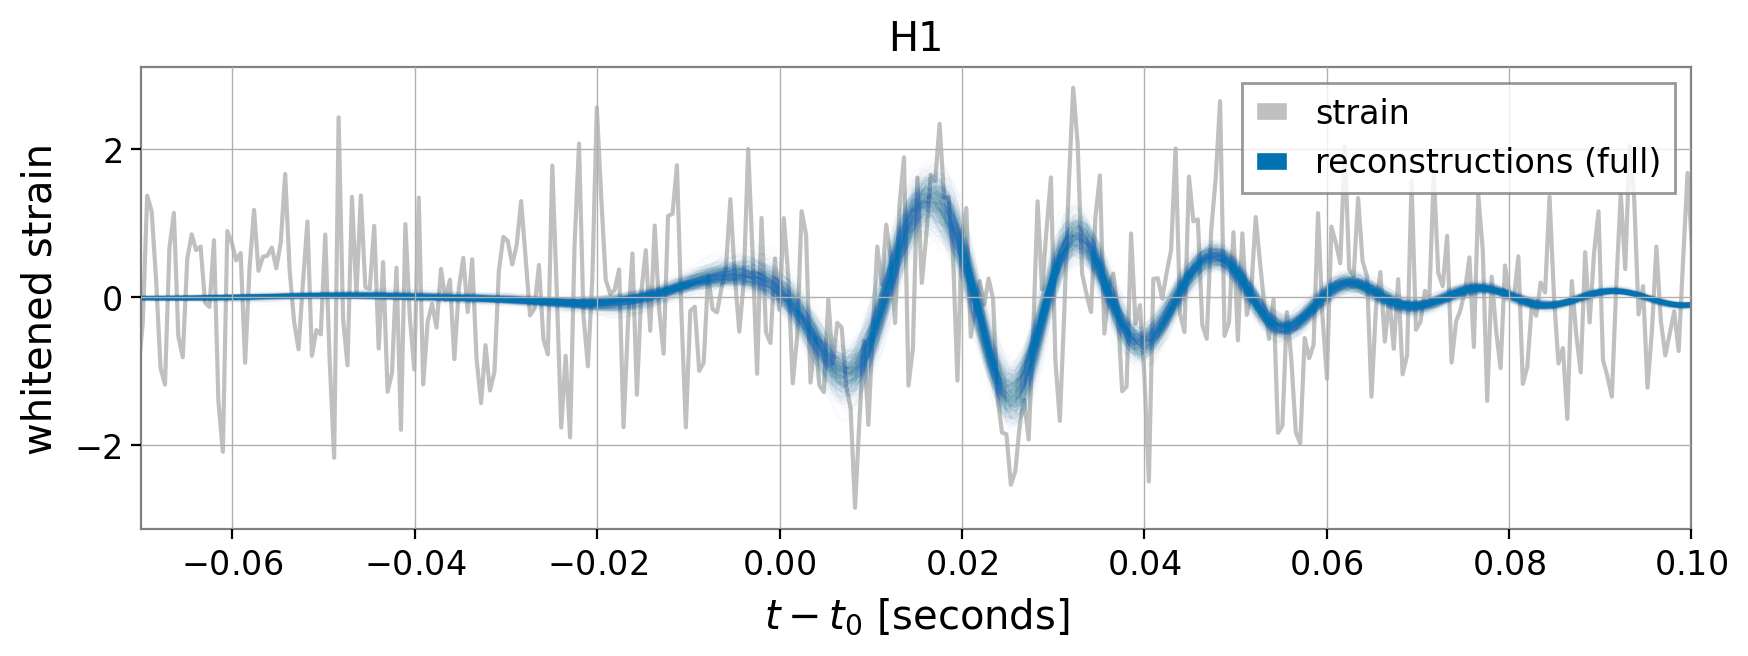

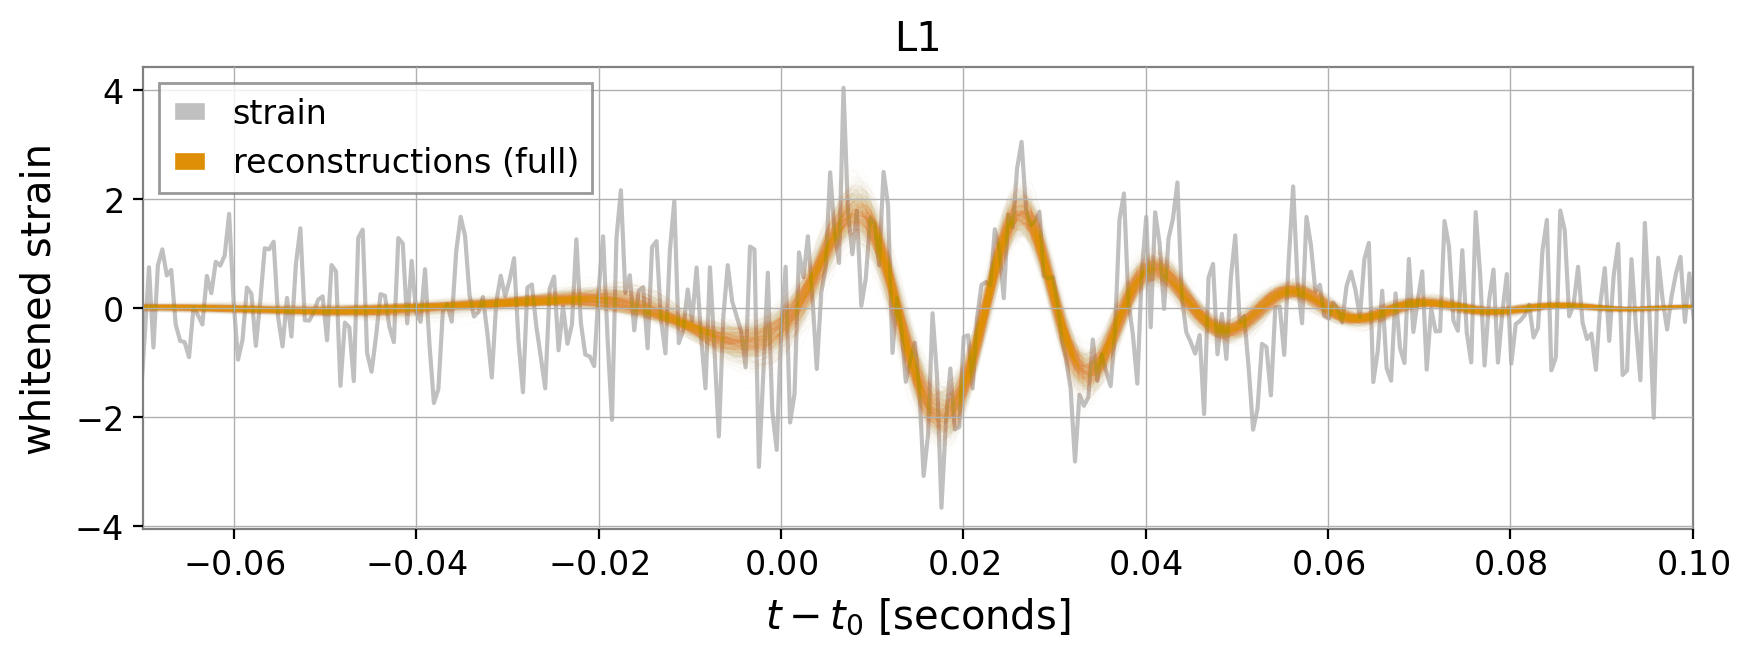

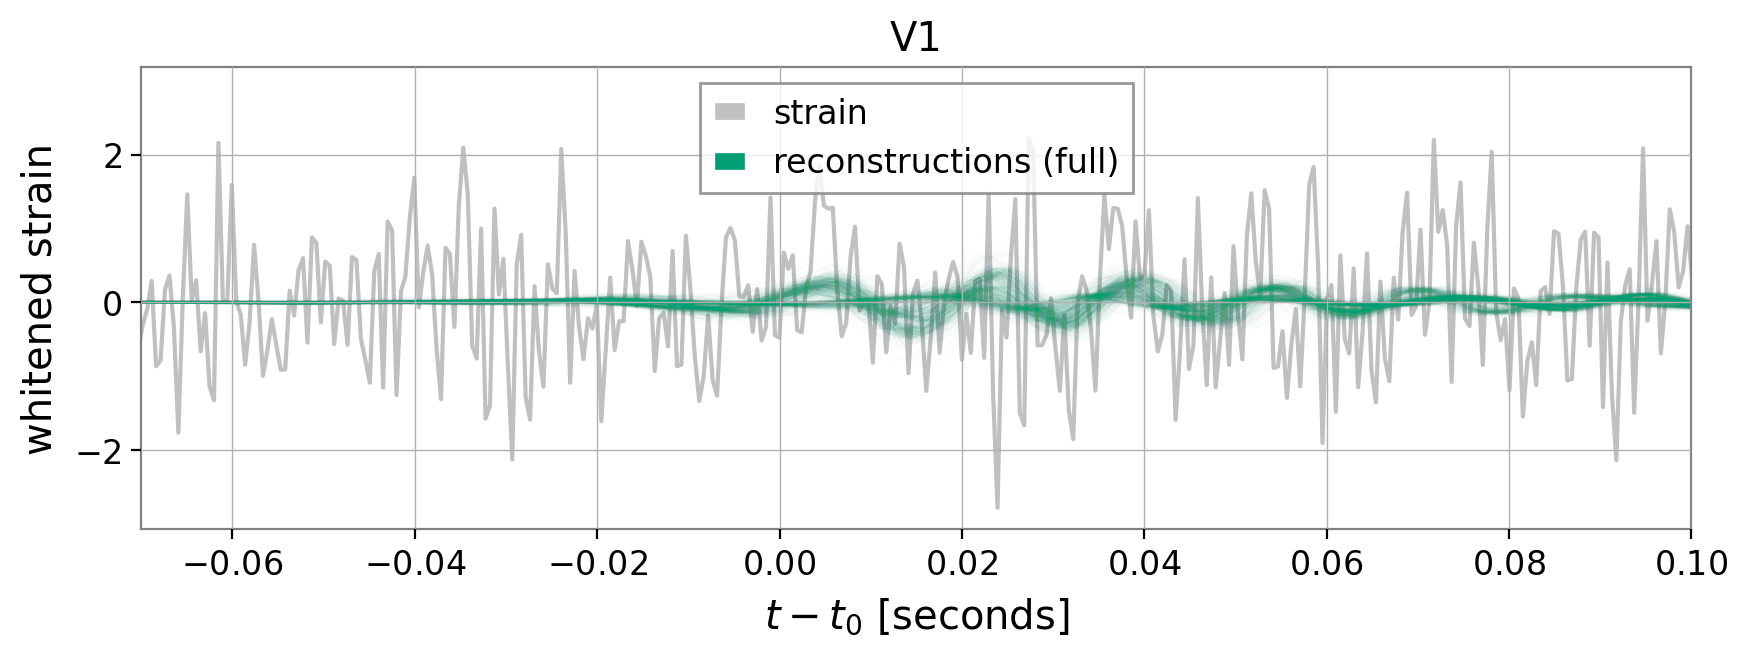

In [12]:
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    time_from_merger = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    
    plt.plot(time_from_merger, data_dict_wh[ifo], color='silver', zorder=0)
    
    for j in range(len(wfs_full_whitened)):
        plt.plot(time_from_merger, wfs_full_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01, zorder=2)

    plt.title(ifo)
    handles = [Line2D([], [], color='silver', label='strain'), Line2D([], [], color=f'C{i}', label='reconstructions (full)')]
    plt.legend(handles=handles)
    plt.xlim(-0.07, 0.1)
    plt.xlabel('$t-t_0$ [seconds]')
    plt.ylabel('whitened strain')
    plt.show()

Plot ringdown-only reconstructions:

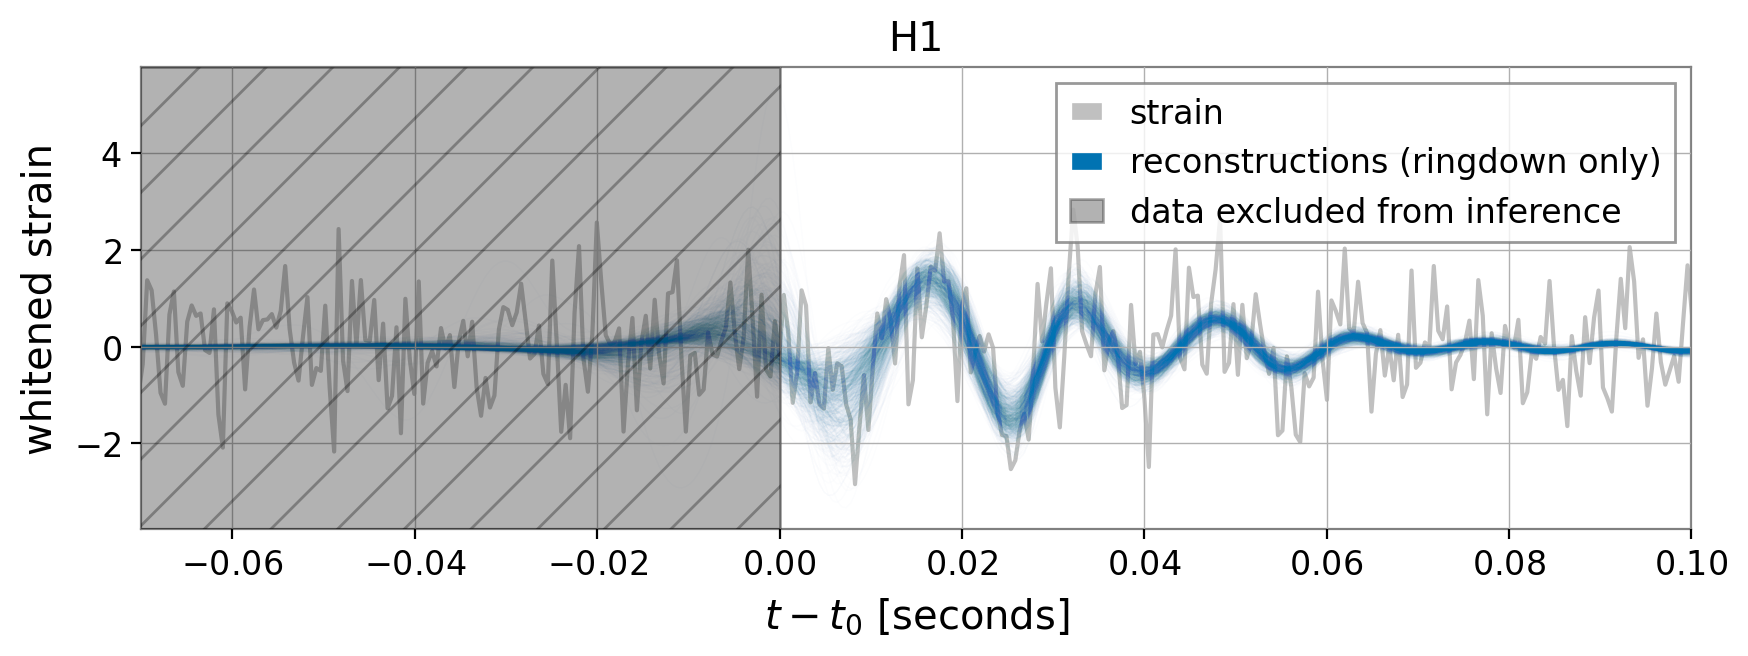

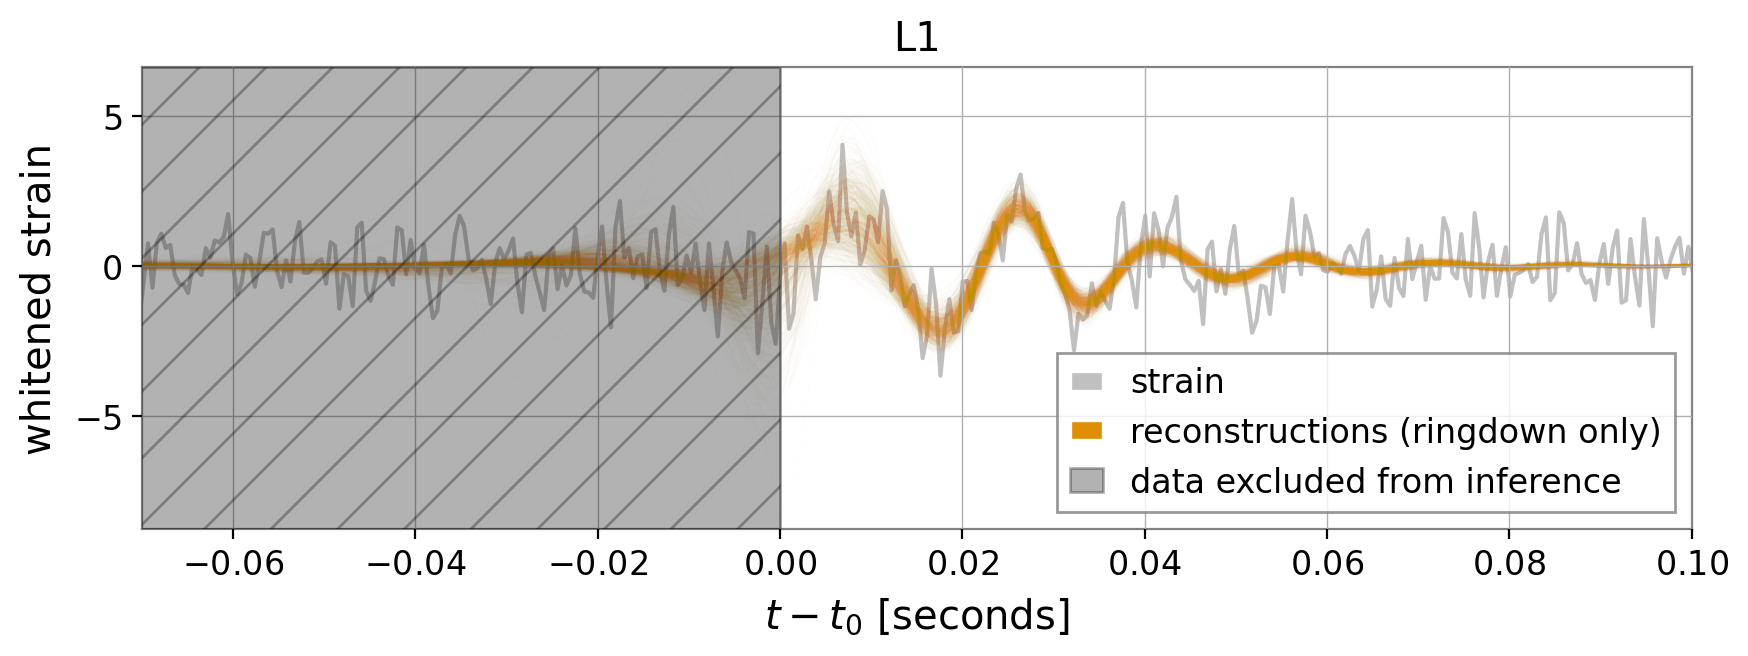

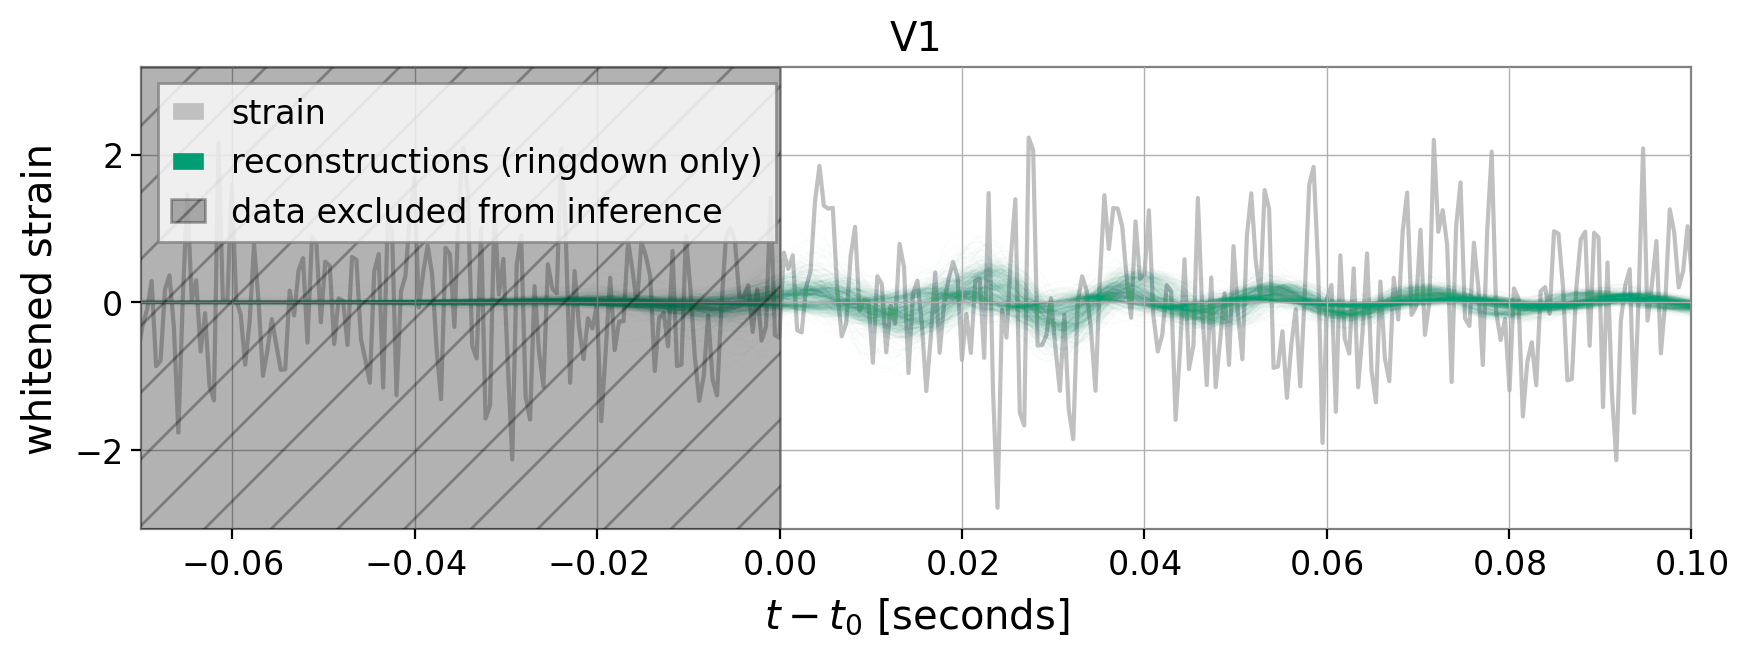

In [13]:
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))

    time_from_merger = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    
    plt.plot(time_from_merger, data_dict_wh[ifo], color='silver', zorder=0)
    
    for j in range(len(wfs_rd_whitened)):
        plt.plot(time_from_merger, wfs_rd_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01, zorder=2)

    plt.title(ifo)
    plt.xlim(-0.07, 0.1)
    plt.xlabel('$t-t_0$ [seconds]')
    plt.ylabel('whitened strain')
    h = plt.axvspan(-0.5, 0, alpha=0.3, color='k', zorder=5, hatch='/', label='data excluded from inference')
    handles = [Line2D([], [], color='silver', label='strain'), Line2D([], [], color=f'C{i}', label='reconstructions (ringdown only)'), h]
    plt.legend(handles=handles)
    plt.show()